In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE
from imblearn.under_sampling import NearMiss, TomekLinks, ClusterCentroids
from collections import Counter

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, LeakyReLU
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import regularizers, metrics


import pickle, os


<h1><center>Preparing for training</center><h1>

In [3]:
# Loading the DS and class names
df = pd.read_csv('classification_cleaned.csv')
df.head()

with open('class_names.pkl', 'rb') as f:
    class_names = pickle.load(f)

In [4]:
df.describe()

,alpha,delta,class,redshift,photometric_filters
count,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000
mean,178.484302,24.833369,0.549711,0.497986,19.875032
std,91.076039,19.001940,0.801556,0.543796,1.638113
min,0.010000,-17.640000,0.000000,-0.010000,13.600000
25%,130.590000,6.980000,0.000000,0.070000,18.577500
50%,181.640000,24.950000,0.000000,0.420000,20.340000
75%,231.380000,40.190000,1.000000,0.660000,21.130000
max,360.000000,70.170000,2.000000,3.250000,24.760000


In [5]:
df['class'].value_counts()

class
0    58299
2    17773
1    13928
Name: count, dtype: int64

In [6]:
# Print clas name 
class_names

['GALAXY', 'QSO', 'STAR']

In [7]:
# I am going to separate features and target columns 
X = df.drop('class', axis=1).values
y = df['class'].values

In [8]:
# Balacing the ds using NearMiss
nm = NearMiss(version=2)
X, y = nm.fit_resample(X, y)
print("Resampled class distribution:", Counter(y))

Resampled class distribution: Counter({0: 13928, 1: 13928, 2: 13928})


In [9]:
# I am going to split the X and y before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
# Feature Scaling:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# I used stratify=y to maintain class balance in splitting
# Also, I fit the scaler only for training data, then transform validation and test to avoid data leakage
# Scale only learns mean and std from training data
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

# Labeling for the model because softmax  gives probabilities for each class
#  One hot encoding let me to  compare these probabilities with true labels using categorical crossentropy
y_train = to_categorical(y_train, num_classes=3)
y_val = to_categorical(y_val, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)
print("One hot encoded:", y_train[70])

Training set: (29248, 4)
Validation set: (6268, 4)
Test set: (6268, 4)
One hot encoded: [1. 0. 0.]


<h1><center>Building the Neural Network Architecture</center><h1>

In [10]:
# I am going to build the model now, I will use Sequential model 
model = Sequential()
model.add(Input(shape=(4,))) 
model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.00001)))
model.add(Dropout(0.15))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,555 (45.14 KB)

 Trainable params: 11,555 (45.14 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Compiling the model:
# I am going to use catergorical crossentropy because it is used for multi class 
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
# Early stopping 
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)
# Reducing learning rate when stuck
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.5, patience=5, verbose=1)


In [12]:
# Training the Model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=300, batch_size=128,
                    callbacks=[early_stop, reduce_lr], verbose=1)

Epoch 1/300
229/229 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8763 - loss: 0.3427 - precision: 0.9299 - recall: 0.7938 - val_accuracy: 0.9556 - val_loss: 0.1437 - val_precision: 0.9565 - val_recall: 0.9550 - learning_rate: 0.0010
Epoch 2/300
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9534 - loss: 0.1432 - precision: 0.9539 - recall: 0.9526 - val_accuracy: 0.9603 - val_loss: 0.1204 - val_precision: 0.9606 - val_recall: 0.9601 - learning_rate: 0.0010
Epoch 3/300
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9595 - loss: 0.1259 - precision: 0.9598 - recall: 0.9590 - val_accuracy: 0.9638 - val_loss: 0.1141 - val_precision: 0.9639 - val_recall: 0.9638 - learning_rate: 0.0010
Epoch 4/300
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9643 - loss: 0.1132 - precision: 0.9645 - recall: 0.9640 - val_accuracy: 0.9673 - val_loss: 0.1051 - val_precision: 0.9673 - val_recall: 0.9673 - learning_rate: 0.0010
Epoch 5/300
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accur

<h1><center>Evaluation</center><h1>

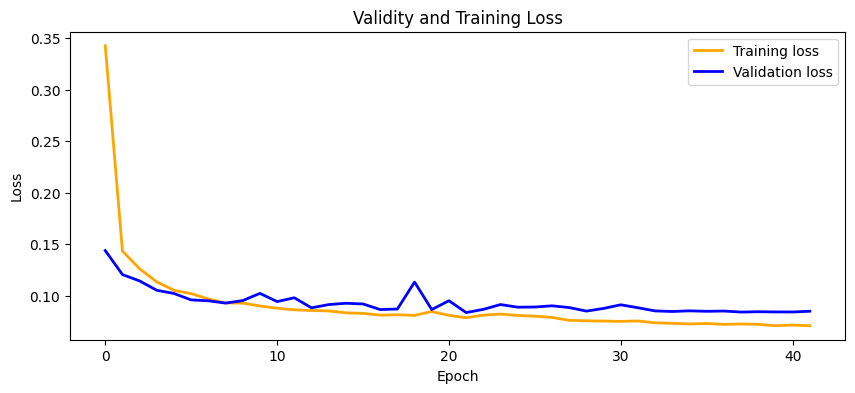

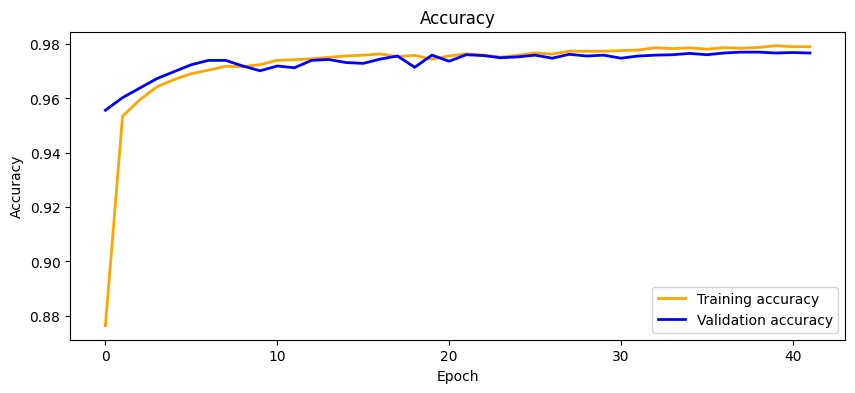

In [13]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(history.history['loss'], label='Training loss', color='orange', linewidth=2, markersize=6)
ax.plot(history.history['val_loss'], label='Validation loss', color='blue', linewidth=2, markersize=6)
ax.set_title('Validity and Training Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(history.history['accuracy'], label='Training accuracy', color='orange', linewidth=2, markersize=6)
ax.plot(history.history['val_accuracy'], label='Validation accuracy', color='blue', linewidth=2, markersize=6)
ax.set_title('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()

# Model learns quickly and  I don t see overfitting
# Val loss and train loss are matching 

In [14]:
# Making predictions
predictions = model.predict(X_test)
predicted_values = np.argmax(predictions, axis=1)
correct_labels = np.argmax(y_test, axis=1)
print("\nClassification Report:\n")
print(classification_report(correct_labels, predicted_values, target_names=class_names))

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step

Classification Report:

              precision    recall  f1-score   support

      GALAXY       0.96      0.98      0.97      2148
         QSO       0.99      0.95      0.97      2032
        STAR       0.99      1.00      1.00      2088

    accuracy                           0.98      6268
   macro avg       0.98      0.98      0.98      6268
weighted avg       0.98      0.98      0.98      6268



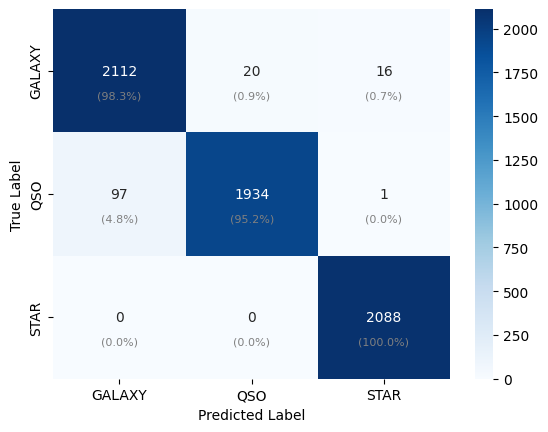

In [15]:
# Confusion Matrix 
Confusion_matrix = confusion_matrix(correct_labels, predicted_values)
# After getting the confusion matrix, I need to convert values to float and sum each row of matrix. for dividing each row by its total
# array must be 2D, so I use None to add new axis
Confusion_matrix_percent = Confusion_matrix.astype('float') / Confusion_matrix.sum(axis=1)[:, None] * 100
sns.heatmap(Confusion_matrix, fmt='d', annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
# Adding new percentages to the confusion matrix
for  i in range(Confusion_matrix.shape[0]):
    for j in range(Confusion_matrix.shape[1]):
        plt.text(j + 0.5, i + 0.7, f'({Confusion_matrix_percent[i, j]:.1f}%)', 
                 ha='center', va='center', fontsize=8, color='gray')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show() 
# I got the code structure from:
# https://stackoverflow.com/questions/20927368/how-to-normalize-a-confusion-matrix
# Almost  5 % of QSO is misclassified as Galaxy 

In [16]:
#  Calculating Uncertainty Monte Carlo Dropout
prediction = []
# 50 times gernerating predictions

for _ in range(50):
    preds = model(X_test, training=True)
    prediction.append(preds)
# I set up the training=True in the model which means dropout is active during prediction
# The predictions will be different each time because of dropout


# Converting to array and calculating statistics
prediction = np.array(prediction)
mean_pred = np.mean(prediction, axis=0)
std_pred = np.std(prediction, axis=0)
uncertainty = np.max(std_pred, axis=1)
print("Uncertainty in Predictions:\n", uncertainty)
# Source : https://medium.com/biased-algorithms/uncertainty-estimation-in-machine-learning-with-monte-carlo-dropout-72377f5ee276

Uncertainty in Predictions:
 [3.0960643e-03 9.0666050e-03 4.9537838e-02 ... 1.3738342e-12 8.5204086e-15
 1.2609564e-02]


In [17]:
prediction.shape

(50, 6268, 3)

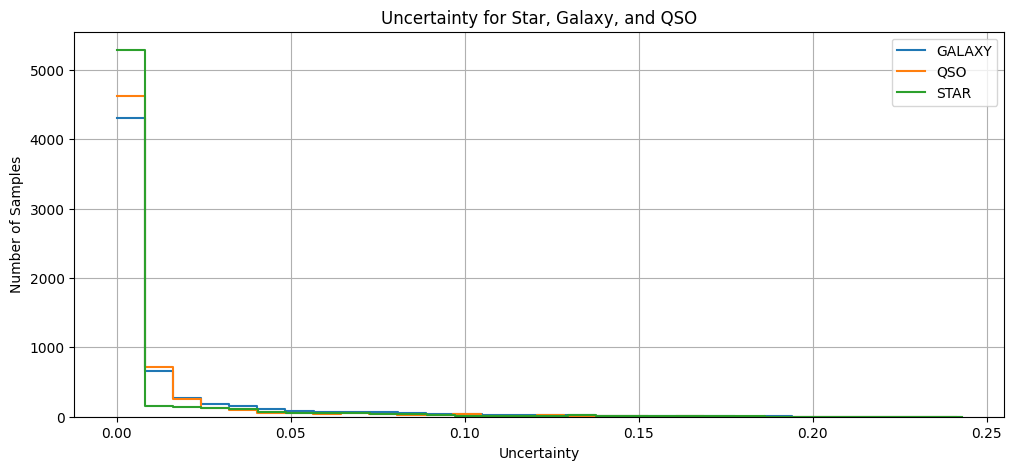

In [18]:
# Visualizing uncertainty 
plt.figure(figsize=(12, 5))
for i in range(3):
    sns.histplot(std_pred[:, i], label=class_names[i], bins=30, element='step', fill=False)
plt.title('Uncertainty for Star, Galaxy, and QSO')
plt.xlabel('Uncertainty')
plt.ylabel('Number of Samples')
plt.grid(True)
plt.legend()
plt.show()
# The model has enough confidence in its predictions

In [19]:
# Testing with new data:
new_data = {
    'alpha': 11.17,
    'delta': 12,
    'redshift': 1.31,
    'photometric_filters': 19
}

new_data_df = pd.DataFrame([new_data])
new_data = scaler.transform(new_data_df.values)


prediction = model.predict(new_data)
predicted_class = np.argmax(prediction, axis=1)[0]
probability = prediction[0]*100

print('Prediction Probabilities:')
for name, percentage in zip(class_names, probability):
    print(f"{name}: {percentage:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction Probabilities:
GALAXY: 0.00%
QSO: 100.00%
STAR: 0.00%


In [22]:
# Save the model and scaler pkle 
model.save('multi_class_model.keras')
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)